In [17]:
import numpy as np
import pandas as pd
import time
import json
import math
from numba import njit, prange, types
from numba.typed import Dict
import matplotlib.pyplot as plt
import os
import preprocessing
import training
import test
import tools
import importlib

# reload moudules
importlib.reload(tools)
importlib.reload(training)
importlib.reload(preprocessing)
importlib.reload(test)

<module 'test' from 'C:\\Users\\dbsrh\\OneDrive\\Desktop\\model-based-CF\\test.py'>

# Preprocessing GroupLens Dataset
For testing a model, divide dataset into two parts, training and test. The original dataset is sequential, hence we should shuffle the dataset randomly. We will build an adjacency matrix for the rating matrix because of the memory limits. The whole rating matrix, about **`280000 X 58000`**, cannot be loaded on memory practically. "userMapper" and "movieMapper" are a hashmap to convert an user and a movie ids into continuous natural number.

In [5]:
# set training - test ratio
train_ratio = 0.8
test_ratio = 1 - train_ratio

# for testing, shuffle dataset
if not os.path.isfile('shuffled_ratings.csv'):
    preprocessing.shuffle_data()
    
ratings = pd.read_csv('shuffled_ratings.csv')
split_bound = int(ratings.shape[0] * train_ratio)

print(f"Load shuffled data : {ratings.shape}")
print(f"Train / Test ratio : {train_ratio} / {test_ratio}")
print(f"Split data : [0:{split_bound}] , [{split_bound}:{ratings.shape[0]}]")

train_data = ratings[:split_bound]
test_data = ratings[split_bound:]
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

# training data
print("##### Get mapper and adjacency matrix")
start_time = time.time()
userMapper = preprocessing.userIdMapper(train_data)
print(f"userMapper processing Time : {time.time() - start_time}")
start_time = time.time()
movieMapper = preprocessing.movieIdMapper(train_data)
print(f"movieMapper processing Time : {time.time() - start_time}")
start_time = time.time()
user_item = preprocessing.build_adjacency_matrix(train_data, userMapper, movieMapper)
print(f"adjacency matrix processing Time : {time.time() - start_time}")

Load shuffled data : (27753444, 4)
Train / Test ratio : 0.8 / 0.19999999999999996
Split data : [0:22202755] , [22202755:27753444]
##### Get mapper and adjacency matrix
userMapper processing Time : 0.3211400508880615
movieMapper processing Time : 0.18952274322509766
adjacency matrix processing Time : 8106.937525510788


# Training model

LFM(Latent Factor Model) is a modeling assuming that there are latent factors to determine an entity. We set 20 dimension features to represent characteristics for each user and movie. These features are the unknown characteristics to calculate a movie rating of a user. This is driven by the assumption that "Some factors absolutely affect to determine rating but, I do not know what the factors are".

Time : 307.0417127609253
###### epoch 0 1.300770809690487
Time : 302.2743446826935
###### epoch 1 1.2679080557498
Time : 302.48478055000305
###### epoch 2 1.2543538343538112
Time : 303.6577317714691
###### epoch 3 1.2458869421464702
Time : 302.0409677028656
###### epoch 4 1.239882007357872
Time : 302.5303153991699
###### epoch 5 1.2352502303697226
Time : 299.1184973716736
###### epoch 6 1.231351467493274
Time : 308.9363920688629
###### epoch 7 1.2277740141279259
Time : 307.31588649749756
###### epoch 8 1.2243977204112657
Time : 307.5912232398987
###### epoch 9 1.2213255480747798


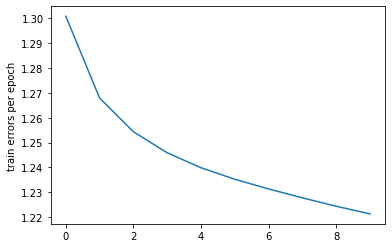

In [9]:
# Collaborative Filtering (Model-based), Trainig
epoch = 10
learning_rate = 0.005
regular_term = 0.1
latent_dim = 20

user_count = len(userMapper.keys())
movie_count = len(movieMapper.keys())

[fm_users, fm_movies, train_error] = tools.load_files(user_count, movie_count, latent_dim)

for i in range(epoch):
    start_time = time.time()
    lossValue = training.training(user_item, fm_users, user_count, fm_movies, learning_rate, regular_term)
    print(f"Time : {time.time() - start_time}")
    train_error.append(lossValue)
    print(f"###### epoch {i} {lossValue}")
    
plt.plot(train_error)
plt.ylabel('train errors per epoch')
plt.show()

# Testing

After training model, we should check whether model is trained well. We already splited the dataset to test the model, therefore we just use it! We measure performance of the model using RMSE(Root Mean Squared Error).

In [18]:
start_time = time.time()
test_err = test.test_error(test_data, fm_users, userMapper, fm_movies, movieMapper)
print(f"Time : {time.time() - start_time}")
print(f"Test dataset error : {test_err}")

Time : 3141.4417424201965
Test dataset error : 0.8761482181999753


This result shows that the model is well trained successfully, because validation set is used to test the model.

In [20]:
tools.save_files(fm_users, fm_movies, train_error)